## Imports:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
# Importing src scripts:
sys.path.insert(0, 'src')
from misc_scripts import scripts
from data import data
from utils import utils
from utils import wordcloud_utils as wu
from models import models
import seaborn as sns
import spacy
from collections import Counter
import re
from wordcloud import WordCloud
import multiprocessing as mp
import pickle
import os
from matplotlib.colors import LinearSegmentedColormap

## Loading datasets:

In [2]:
#Load CMU Corpus Dataset
metadata = data.load_metadata()
summaries_df = data.load_summaries()
cmu_df = metadata.merge(summaries_df, on="Wikipedia_movie_ID") 
#Load IMDB dataset
characters = pd.read_table(f"data/MovieSummaries/character.metadata.tsv", header=None)

characters.columns = [
"Wikipedia_movie_ID",
"Freebase movie ID",
"Movie release date",
"Character name",
"Actor date of birth",
"Actor gender",
"Actor height (in meters)",
"Actor ethnicity (Freebase ID)",
"Actor name",
"Actor age at movie release",
"Freebase character/actor map ID",
"Freebase character ID",
"Freebase actor ID"
]

# Merging character database with summaries
characters =  characters[["Wikipedia_movie_ID", "Actor gender", "Character name"]]
characters = characters.groupby("Wikipedia_movie_ID").agg({
    "Actor gender": list, 
    "Character name": list,
}).reset_index()

char_sum_CMU = pd.merge(cmu_df, characters, on="Wikipedia_movie_ID", how="inner")
# keeping only relevant columns
char_sum_CMU = char_sum_CMU[["Wikipedia_movie_ID", "Actor gender", "Character name","Movie_Summary","Movie_box_office_revenue"]]


## Adding female percentage as column

In [3]:
# Create the new column with the female percentage
char_sum_CMU['Female Percentage'] = char_sum_CMU['Actor gender'].apply(wu.calculate_female_percentage)
char_sum_CMU = char_sum_CMU[char_sum_CMU['Female Percentage'] != -1]

In [4]:
female_movies = char_sum_CMU[char_sum_CMU["Female Percentage"] >= 66].copy()
male_movies = char_sum_CMU[char_sum_CMU["Female Percentage"] <= 33].copy()
print('Number of movies with high female ratio: ', len(female_movies))
print('Number of movies with high male ratio: ', len(male_movies))

Number of movies with high female ratio:  3429
Number of movies with high male ratio:  17466


# Plotting distribution of female percentage:

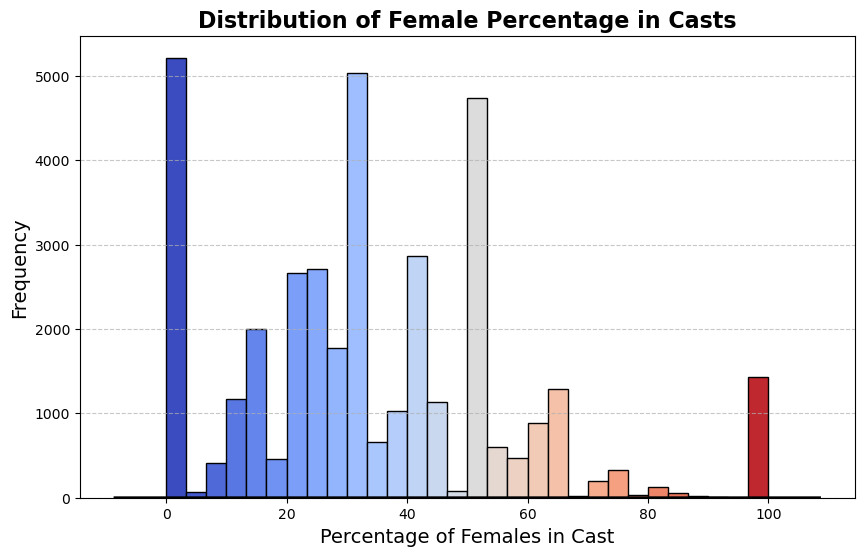

In [5]:
wu.plot_female_percentage_graph(char_sum_CMU)

# Finding character keywords in the summaries:

In [8]:
# Extract adjectives and verbs from each movie summary for the female df
if os.path.exists("data/pickles/female_movies.pkl"):
    female_movies = pd.read_pickle("data/pickles/female_movies.pkl")
else:
    female_movies['Adj_Tokens'] = wu.parallel_apply_multiprocessing(female_movies['Movie_Summary'],wu.extract_adj,n_cores=mp.cpu_count())
    female_movies['Verb_Tokens'] = wu.parallel_apply_multiprocessing(female_movies['Movie_Summary'],wu.extract_verb,n_cores=mp.cpu_count())
    female_movies.to_pickle("data/pickles/female_movies.pkl")

Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:


KeyboardInterrupt: 

In [7]:
# Extract adjectives and verbs from each movie summary for the male df
if os.path.exists("data/pickles/male_movies.pkl"):
    male_movies = pd.read_pickle("data/pickles/male_movies.pkl")
else:
    male_movies['Adj_Tokens'] = wu.parallel_apply_multiprocessing(male_movies['Movie_Summary'],wu.extract_adj,n_cores=mp.cpu_count())
    male_movies['Verb_Tokens'] = wu.parallel_apply_multiprocessing(male_movies['Movie_Summary'],wu.extract_verb,n_cores=mp.cpu_count())
    male_movies.to_pickle("data/pickles/male_movies.pkl")

In [56]:
# import pickle
# import spacy
# from collections import Counter
# import re
# from wordcloud import WordCloud
# import multiprocessing as mp


In [57]:
female_movies
male_movies

,Wikipedia_movie_ID,Actor gender,Character name,Movie_Summary,Female Percentage,Adj_Tokens,Verb_Tokens
3,18998739,"[nan, F, M, M, M, nan, nan, M]","[nan, Morgana, nan, nan, nan, nan, nan, nan]","Every hundred years, the evil Morgana returns...",20.000000,"[evil, last, new, elderly, natural, old, same,...","[return, claim, intend, destroy, fail, intend,..."
5,171005,"[M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...","[Henry V, nan, nan, nan, Catherine of Valois, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,15.000000,"[brief, romantic, french, english, royal, greek]","[make, name, have, negotiate, inform, last, li..."
9,32456683,[M],[nan],"Otto Brosowski, a communist miner, writes to t...",0.000000,"[communist, soviet, harsh, capitalist, hard, g...","[write, tell, work, demand, receive, seize, hi..."
11,20604092,[M],[nan],The film opens with a simpleton from a small v...,0.000000,"[small, big, good, famous, successful, many, i...","[open, want, become, play, go, meet, help, pra..."
14,9633533,"[F, M, M, F, M, M, M, M, M]","[nan, Unnikrishnan, nan, nan, nan, nan, Advert...","Professor Kurian Fernandez , a convict escapes...",22.222222,"[several, only, opposite, interested, full, fl...","[fail, chase, nab, draw, capture, feel, land, ..."
...,...,...,...,...,...,...,...
37768,21975745,[M],[nan],The story begins with young Bobby and his frie...,0.000000,"[young, strict, mean, beagle, lost, unconsciou...","[begin, have, refuse, return, hear, realize, l..."
37771,26044505,"[nan, M, M, M]","[nan, nan, nan, nan]",Insane archaeologist Professor Andrew Forbes ...,0.000000,[aztec],"[use, unearth, kill, know, try, stop]"
37773,1918494,"[nan, M, M, M, M, F, M, F, M, nan, M, F, M, M,...","[Maude, Doc Wilson, Bunky, Spud, Doug Mackenzi...",Havoc is wrought on the inhabitants of a small...,18.181818,"[small, troubled, teenage, small, genuine, onl...","[work, lead, get, banish, relocate, finish, sh..."
37776,15394941,"[M, M, M, F, F, F, M, F, M, M, M, M, M, M]","[Rajeshwar Choudhary, Gopinath, Kishan R. Chou...",Kishan killed a man in his childhood when the...,28.571429,"[alive, precious, powerful, vulnerable, coward...","[kill, abuse, go, remand, come, harden, meet, ..."


In [58]:
from itertools import chain
# Flatten the list of all adjectives and verbs
fem_adj_flat = np.array(list(chain.from_iterable(female_movies["Adj_Tokens"])))
fem_verb_flat = np.array(list(chain.from_iterable(female_movies["Verb_Tokens"])))
male_adj_flat = np.array(list(chain.from_iterable(male_movies["Adj_Tokens"])))
male_verb_flat = np.array(list(chain.from_iterable(male_movies["Verb_Tokens"])))
fem_adj_flat

array(['hard', 'next', 'reluctant', ..., 'huge', 'much', 'bad'],
      dtype='<U106')

In [59]:
# Count word frequencies using Counter
fem_adj_counts = Counter(fem_adj_flat)
fem_verb_counts = Counter(fem_verb_flat)
male_verb_counts = Counter(male_verb_flat)
male_adj_counts = Counter(male_adj_flat)

In [60]:
# Function to normalize counts and filter words with similar relative frequencies (within 10%)
def filter_similar_counts(counter1, counter2, threshold=0.4):
    # Calculate total counts for each Counter to normalize
    total_count1 = sum(counter1.values())
    total_count2 = sum(counter2.values())

    # Calculate relative frequencies
    relative_freqs1 = {word: count / total_count1 for word, count in counter1.items()}
    relative_freqs2 = {word: count / total_count2 for word, count in counter2.items()}

    # Initialize filtered counters
    filtered_counter1 = Counter()
    filtered_counter2 = Counter()

    # Get the intersection of words from both counters
    common_keys = set(relative_freqs1.keys()).intersection(set(relative_freqs2.keys()))

    for word in common_keys:
        freq1 = relative_freqs1[word]
        freq2 = relative_freqs2[word]

        # Calculate the percentage difference between relative frequencies
        if abs(freq1 - freq2) / max(freq1, freq2) > threshold:
            # If the difference is greater than threshold, keep the word
            filtered_counter1[word] = counter1[word]
            filtered_counter2[word] = counter2[word]

    # Add words that are unique to each counter
    unique_keys1 = set(counter1.keys()).difference(set(counter2.keys()))
    unique_keys2 = set(counter2.keys()).difference(set(counter1.keys()))

    for word in unique_keys1:
        filtered_counter1[word] = counter1[word]

    for word in unique_keys2:
        filtered_counter2[word] = counter2[word]

    return filtered_counter1, filtered_counter2

fem_adj_counts, male_adj_counts = filter_similar_counts(fem_adj_counts, male_adj_counts)
fem_verb_counts, male_verb_counts = filter_similar_counts(fem_verb_counts, male_verb_counts,.7)

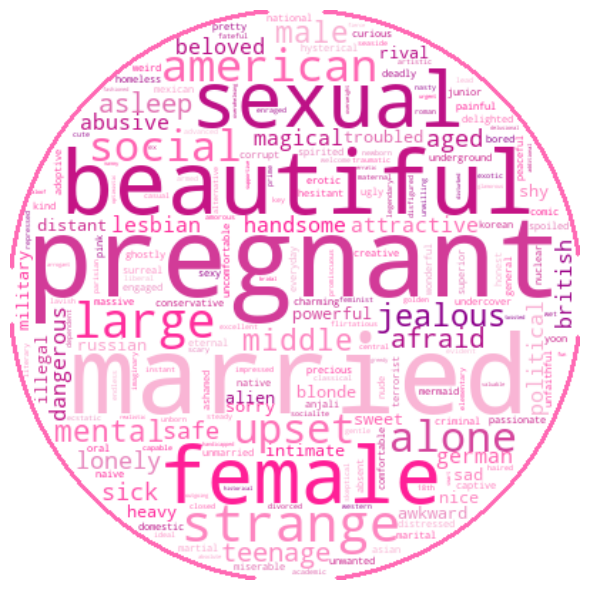

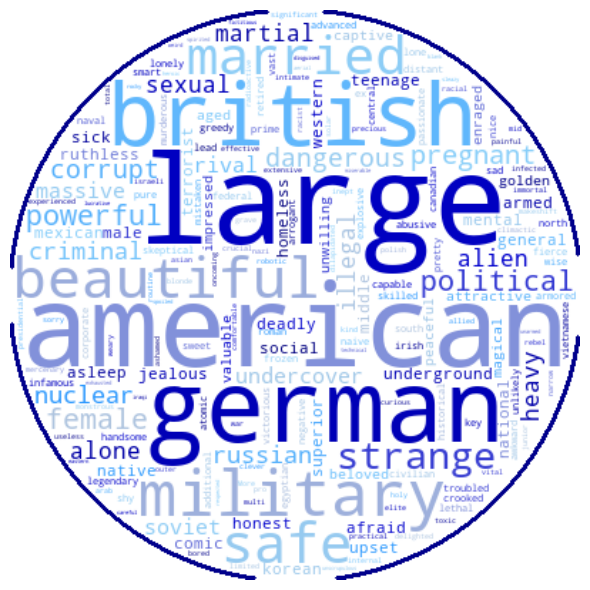

In [66]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define adjusted high-contrast color maps with no pure white
adjusted_female_colors = LinearSegmentedColormap.from_list(
    "adjusted_female", ["#FF1493", "#FF69B4", "#F8BFD9", "#C71585", "#8B008B"]
)
adjusted_male_colors = LinearSegmentedColormap.from_list(
    "adjusted_male", ["#1E90FF", "#87CEFA", "#B0C4DE", "#0000CD", "#000080"]
)

# Create a mask for the word cloud (ellipse-shaped mask)
def create_ellipse_mask(width, height):
    y, x = np.ogrid[:height, :width]
    center_x, center_y = width / 2, height / 2
    mask = (x - center_x) ** 2 / (width / 2) ** 2 + (y - center_y) ** 2 / (height / 2) ** 2 <= 1
    # Invert the mask (255 inside the ellipse, 0 outside)
    return 255 - 255 * mask.astype(np.uint8)

ellipse_mask = create_ellipse_mask(400, 400)

# Generate the word cloud for female adjectives
wordcloud_fem = WordCloud(
    width=400, height=400,
    background_color='white',
    colormap=adjusted_female_colors,
    mask=ellipse_mask,
    contour_width=2,
    contour_color='hotpink'
).generate_from_frequencies(fem_adj_counts)

# Display the female word cloud
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_fem, interpolation='bilinear')
plt.axis('off')
# plt.title('Most Common Adjectives for Female Dominant Films', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('female_adj_wordcloud.png')
plt.show()

# Generate the word cloud for male adjectives
wordcloud_male = WordCloud(
    width=400, height=400,
    background_color='white',
    colormap=adjusted_male_colors,
    mask=ellipse_mask,
    contour_width=2,
    contour_color='darkblue'
).generate_from_frequencies(male_adj_counts)

# Display the male word cloud
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_male, interpolation='bilinear')
plt.axis('off')
# plt.title('Most Common Adjectives for Male Dominant Films', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('male_adj_wordcloud.png')
plt.show()


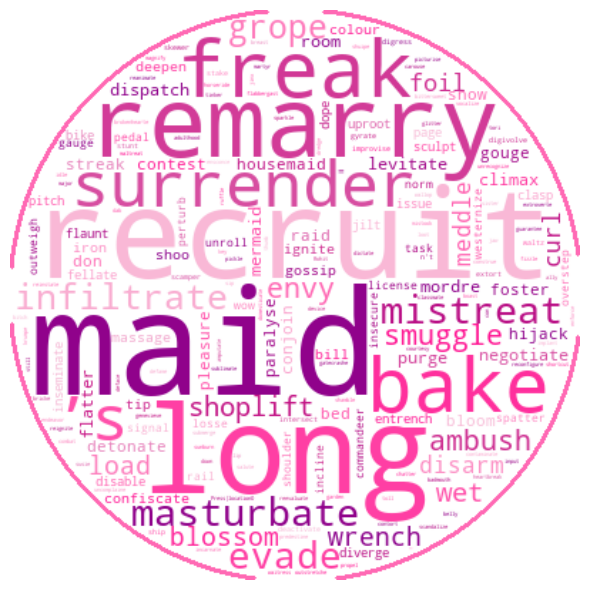

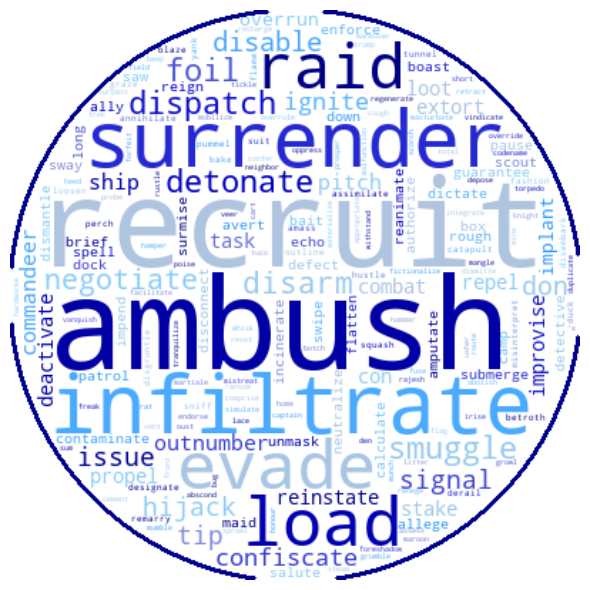

In [68]:

# Generate the word cloud for female verbs
wordcloud_fem = WordCloud(
    width=400, height=400,
    background_color='white',
    colormap=adjusted_female_colors,
    mask=ellipse_mask,
    contour_width=2,
    contour_color='hotpink'
).generate_from_frequencies(fem_verb_counts)

# Display the female word cloud
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_fem, interpolation='bilinear')
plt.axis('off')
# plt.title('Most Common Verbs for Female Dominant Films', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('female_verb_wordcloud.png')
plt.show()

# Generate the word cloud for male verbs
wordcloud_male = WordCloud(
    width=400, height=400,
    background_color='white',
    colormap=adjusted_male_colors,
    mask=ellipse_mask,
    contour_width=2,
    contour_color='darkblue'
).generate_from_frequencies(male_verb_counts)

# Display the male word cloud
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_male, interpolation='bilinear')
plt.axis('off')
# plt.title('Most Common Verbs for Male Dominant Films', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('male_verb_wordcloud.png')
plt.show()


# Finding connections between movie revenue and gender ratio

In [9]:
char_sum_CMU

,Wikipedia_movie_ID,Actor gender,Character name,Movie_Summary,Movie_box_office_revenue,Female Percentage
0,975900,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Akooshay, Lieutenant Melanie Ballard, Desolat...","Set in the second half of the 22nd century, th...",14010832.0,35.294118
1,9363483,"[M, F]","[nan, nan]",A series of murders of rich young women throug...,NaN,50.000000
2,261236,"[F, M, M]","[nan, nan, nan]","Eva, an upper class housewife, becomes frustra...",NaN,33.333333
3,18998739,"[nan, F, M, M, M, nan, nan, M]","[nan, Morgana, nan, nan, nan, nan, nan, nan]","Every hundred years, the evil Morgana returns...",NaN,20.000000
4,6631279,"[M, F, F, M, F, F]","[nan, Rebecca, Nina, nan, nan, nan]","Adam, a San Francisco-based artist who works a...",NaN,66.666667
...,...,...,...,...,...,...
37776,15394941,"[M, M, M, F, F, F, M, F, M, M, M, M, M, M]","[Rajeshwar Choudhary, Gopinath, Kishan R. Chou...",Kishan killed a man in his childhood when the...,NaN,28.571429
37777,26482675,[M],[nan],"The film is about two friends, Tayyar , a mafi...",1847671.0,0.000000
37778,23851782,"[F, M, F, M, M, nan, F, M, nan, F, M, M, M]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",{{plot}} The film opens with a Great Western e...,NaN,36.363636
37779,913762,"[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]","[Mesena, Hibiki, Ishtar, Sylvie, Exegran, Addi...","The story takes place in the year 2092,The Sup...",NaN,33.333333


In [10]:
char_sum_CMU = char_sum_CMU.dropna(subset=['Movie_box_office_revenue'], how='any')
char_sum_CMU

,Wikipedia_movie_ID,Actor gender,Character name,Movie_Summary,Movie_box_office_revenue,Female Percentage
0,975900,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Akooshay, Lieutenant Melanie Ballard, Desolat...","Set in the second half of the 22nd century, th...",14010832.0,35.294118
5,171005,"[M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...","[Henry V, nan, nan, nan, Catherine of Valois, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,10161099.0,15.000000
8,77856,"[F, M, M, F, M, M, F, M, F, F, F, M, M]","[Jane Banks, George Banks, Bert, Mary Poppins,...",The film opens with Mary Poppins perched in a...,102272727.0,46.153846
12,156558,"[F, M, nan, M, nan, F, nan, F, F, F, nan, nan,...","[Yvette, Jody, nan, nan, Já Toi, Mourner, Lil'...",A young 20-year-old named Jody lives with his...,29381649.0,52.173913
21,261237,"[nan, nan, nan, M, nan, nan, M, M, F, M, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",The film is a collision of three separate stor...,34331783.0,14.285714
...,...,...,...,...,...,...
37762,54540,"[F, M, M, M, M, M, F, F, M, M, M, M, F, M, M, ...","[Imani Izzi, Randy Watson, Prince Akeem, Semmi...","Akeem Joffer , the prince and heir to the thro...",288752301.0,28.571429
37770,7761830,"[F, F, M, M, M, M, F, M, M]","[nan, Kathy, nan, nan, nan, nan, nan, nan, nan]","The space armada from Mars, known as the Imper...",15369573.0,33.333333
37773,1918494,"[nan, M, M, M, M, F, M, F, M, nan, M, F, M, M,...","[Maude, Doc Wilson, Bunky, Spud, Doug Mackenzi...",Havoc is wrought on the inhabitants of a small...,6944471.0,18.181818
37774,664006,"[M, F, F, M, M, M, M, F]","[David Edgar Greenhill, nan, nan, nan, nan, na...",Jennifer Haines is an up-and-coming Chicago a...,22886222.0,37.500000


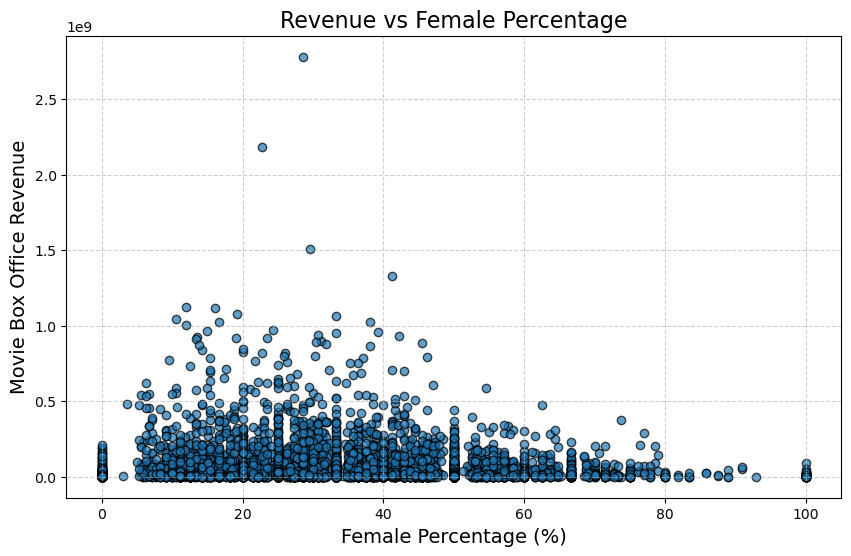

In [11]:
# Scatterplot of revenue vs female percentage
plt.figure(figsize=(10, 6))
plt.scatter(
    char_sum_CMU["Female Percentage"],
    char_sum_CMU["Movie_box_office_revenue"],
    alpha=0.7,
    edgecolor="k"
)
plt.title("Revenue vs Female Percentage", fontsize=16)
plt.xlabel("Female Percentage (%)", fontsize=14)
plt.ylabel("Movie Box Office Revenue", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


/tmp/ipykernel_21324/671311505.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_sum_CMU['Female_Percentage_Bins'] = pd.cut(char_sum_CMU['Female Percentage'], bins=bins, labels=labels, include_lowest=True)


<Figure size 1200x600 with 0 Axes>

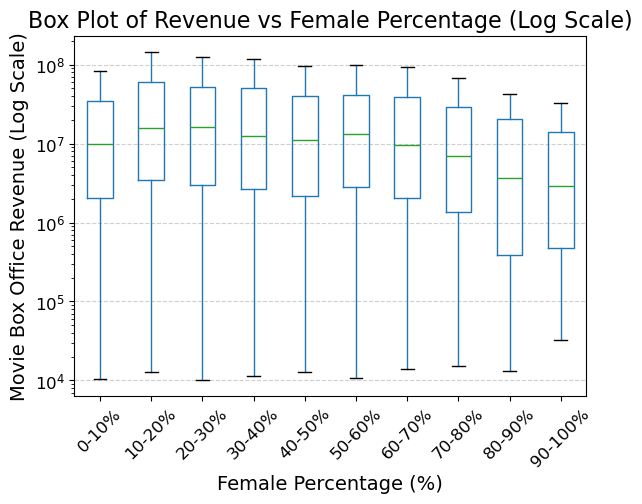

In [15]:

# Bin the Female Percentage into groups using linspace
bins = np.linspace(0, 100, 11)  # Create 10 bins from 0 to 100
labels = [f'{int(bins[i])}-{int(bins[i+1])}%' for i in range(len(bins) - 1)]
char_sum_CMU['Female_Percentage_Bins'] = pd.cut(char_sum_CMU['Female Percentage'], bins=bins, labels=labels, include_lowest=True)

# Create the boxplot
plt.figure(figsize=(12, 6))
boxplot = char_sum_CMU.boxplot(
    column='Movie_box_office_revenue', 
    by='Female_Percentage_Bins', 
    grid=False, 
    showfliers=False
)

# Apply log scale to the revenue axis
plt.yscale('log')
plt.title('Box Plot of Revenue vs Female Percentage (Log Scale)', fontsize=16)
plt.suptitle('')  # Remove default subplot title
plt.xlabel('Female Percentage (%)', fontsize=14)
plt.ylabel('Movie Box Office Revenue (Log Scale)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

/tmp/ipykernel_21324/3248855347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_sum_CMU['Female_Percentage_Bins'] = pd.cut(char_sum_CMU['Female Percentage'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_21324/3248855347.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


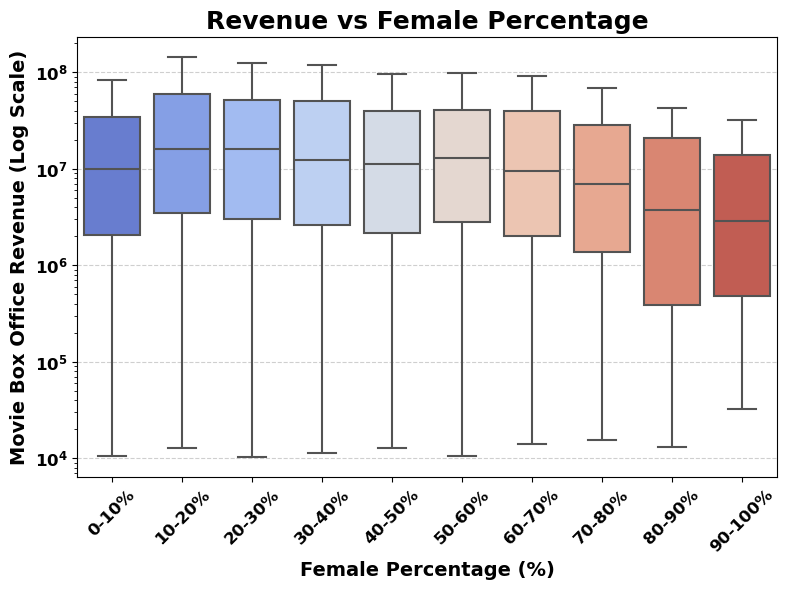

In [25]:
import seaborn as sns

# Bin the Female Percentage into groups using linspace
bins = np.linspace(0, 100, 11)  # Create 10 bins from 0 to 100
labels = [f'{int(bins[i])}-{int(bins[i+1])}%' for i in range(len(bins) - 1)]
char_sum_CMU['Female_Percentage_Bins'] = pd.cut(char_sum_CMU['Female Percentage'], bins=bins, labels=labels, include_lowest=True)

# Create a custom blue-to-pink gradient palette
palette = sns.color_palette("coolwarm", len(labels))

# Create the boxplot with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='Female_Percentage_Bins',
    y='Movie_box_office_revenue',
    data=char_sum_CMU,
    showfliers=False,  # Hide outliers for cleaner visuals
    palette=palette,  # Aesthetic color palette
    linewidth=1.5
)

# Apply log scale to the revenue axis
plt.yscale('log')

# Customize the plot
plt.title('Revenue vs Female Percentage', fontsize=18, fontweight='bold')
plt.xlabel('Female Percentage (%)', fontsize=14, fontweight='bold')
plt.ylabel('Movie Box Office Revenue (Log Scale)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add a legend or annotations if required
plt.tight_layout()
plt.savefig('revenue_vs_female_percentage.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
from scipy.stats import pearsonr, spearmanr

# Clean data: Remove rows with NaN values in the relevant columns
cleaned_data = char_sum_CMU.dropna(subset=['Female Percentage', 'Movie_box_office_revenue'])

# Log-transform revenue for normalization (optional but helps with skewed data)
cleaned_data['Log_Revenue'] = np.log(cleaned_data['Movie_box_office_revenue'] + 1)

# Perform Pearson correlation test
pearson_corr, pearson_p_value = pearsonr(cleaned_data['Female Percentage'], cleaned_data['Log_Revenue'])

# Perform Spearman correlation test
spearman_corr, spearman_p_value = spearmanr(cleaned_data['Female Percentage'], cleaned_data['Log_Revenue'])

# Output results
print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {pearson_p_value:.3e}")
print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {spearman_p_value:.3e}")

# Interpret results
alpha = 0.05  # Significance level
if pearson_p_value < alpha:
    print("The Pearson test indicates a significant relationship between gender ratio and revenue.")
else:
    print("The Pearson test does not indicate a significant relationship.")

if spearman_p_value < alpha:
    print("The Spearman test indicates a significant relationship between gender ratio and revenue.")
else:
    print("The Spearman test does not indicate a significant relationship.")


Pearson Correlation: -0.072, p-value: 4.157e-10
Spearman Correlation: -0.067, p-value: 7.879e-09
The Pearson test indicates a significant relationship between gender ratio and revenue.
The Spearman test indicates a significant relationship between gender ratio and revenue.
